# Complex model 2

This code illustrates how to create a complex model and simulate its total-field anomaly.

### Things we have to import

In [1]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

# PyVista is a helper library for the Visualization Toolkit (VTK) that takes 
# a different approach on interfacing with VTK through NumPy and direct array access.
# https://docs.pyvista.org/version/stable/
import pyvista as pv

# Python package noise (https://github.com/caseman/noise) for generating Perlin noise.
# Such noise is usefull to simulate topography.
import noise

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

In [4]:
import pickle

In [5]:
import numpy as np
from gravmag import data_structures, utils
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [6]:
import time

### Set the model area and number of prisms along the horizontal directions

In [7]:
# number of prisms forming the model along the x and y directions
model_shape = (40, 50)

# minimum x, maximum x, minimum y and maximum y
model_area = [-5100, 4900, -3800, 6200]

In [8]:
model_dx, model_dy = data_structures.grid_xy_spacing(area=model_area, shape=model_shape)
print('model dx = {:.3f} m | model dy = {:.3f} m'.format(model_dx, model_dy))

model dx = 256.410 m | model dy = 204.082 m


### Define a reference surface on which the model will be attached

In [9]:
# horizontal boundaries of the prisms
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = np.linspace(
        model_area[0] + 0.5*model_dx, 
        model_area[1] - 0.5*model_dx, 
        model_shape[0]
    ),
    y = np.linspace(
        model_area[2] + 0.5*model_dy, 
        model_area[3] - 0.5*model_dy, 
        model_shape[1]
    ),
    shape = model_shape
)

In [10]:
# reference point
xc = 0.5*(model_area[0]+model_area[1])
yc = 0.5*(model_area[2]+model_area[3])

# polynomial function defining the reference surface
reference_surface = 300. - 1e-2*(X-xc) - 1e-2*(Y-yc)

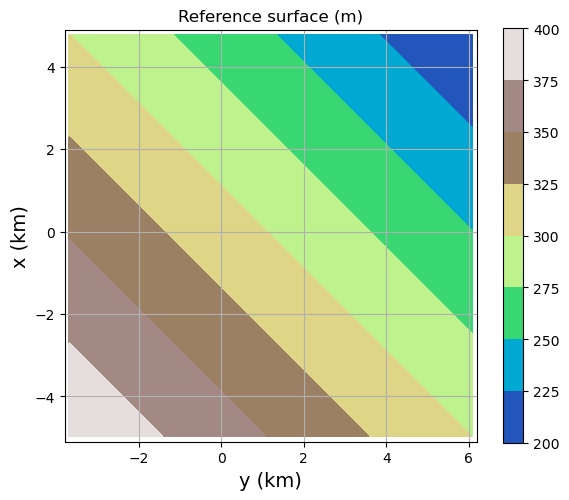

In [11]:
plt.figure(figsize=(6,5))

plt.title("Reference surface (m)")
plt.axis('scaled')
plt.contourf(Y*0.001, X*0.001, reference_surface, cmap='terrain', vmin = np.min(reference_surface), vmax = np.max(reference_surface))
plt.colorbar()
plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()
plt.tight_layout()

plt.show()

### Define/Load the thickness of all rectangular cells covering the simulated area

In [12]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

# Generate a synthetic random surfaces with the Python package [`noise`](https://pypi.org/project/noise/),
# by following the example presented at [Jack McKew's Blog](https://jackmckew.dev/3d-terrain-in-python.html)

# parameters controlling the surface
amplitude = 500.

# generate the surface
thickness = np.zeros(model_shape)
for i in range(model_shape[0]):
    for j in range(model_shape[1]):
        thickness[i][j] = noise.pnoise2(
            i/45, 
            j/15, 
            octaves=20, 
            persistence=0.1,
            lacunarity=8, 
            repeatx=20, 
            repeaty=14, 
            base=0
        )
thickness = (
    amplitude*(
        (thickness - np.min(thickness))/(np.max(thickness) - np.min(thickness))
    )
)

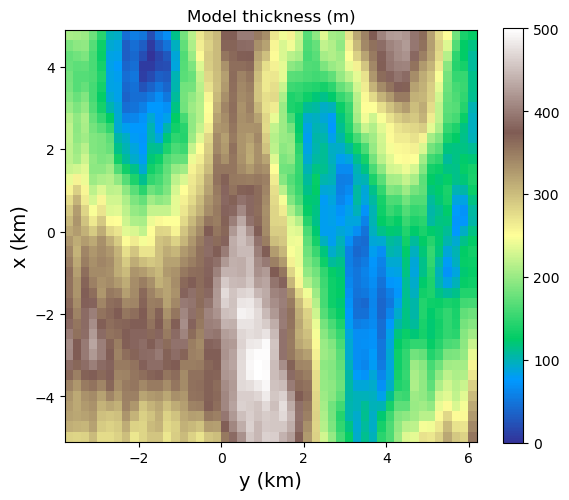

In [13]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

plt.figure(figsize=(6,5))

plt.title("Model thickness (m)")
plt.axis('scaled')
plt.pcolor(
    Y*0.001, X*0.001, thickness, cmap='terrain')
plt.colorbar()
#plf.model_boundaries(model)
plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)

plt.tight_layout()

plt.show()

### Pick/Load points forming the horizontal model boundary

In [14]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

boundary_points = pickle.load(open('models/complex_model_2/boundary_points.pickle', 'rb'))

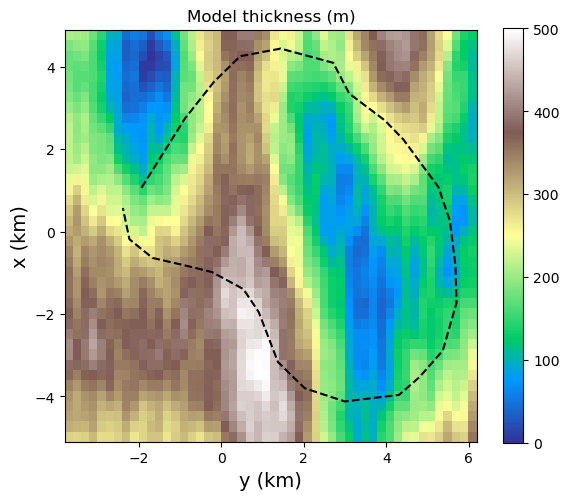

In [15]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

plt.figure(figsize=(6,5))

plt.title("Model thickness (m)")
plt.axis('scaled')
plt.pcolor(
    Y*0.001, X*0.001, thickness, cmap='terrain')
plt.colorbar()

plt.plot(boundary_points[:,1]*1e-3, boundary_points[:,0]*1e-3, '--k')

plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)


plt.tight_layout()

plt.show()

### Filter/Load the cells inside the boundary

In [16]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

Boundary = Polygon(shell=boundary_points[:,::-1])

In [17]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

mask = np.empty(shape=model_shape, dtype=bool)

In [18]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

for i in range(model_shape[0]):
    for j in range(model_shape[1]):
        mask[i,j] = Boundary.contains(Point(Y[i,j], X[i,j]))

/tmp/ipykernel_24232/3722018461.py:12: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_24232/3722018461.py:29: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


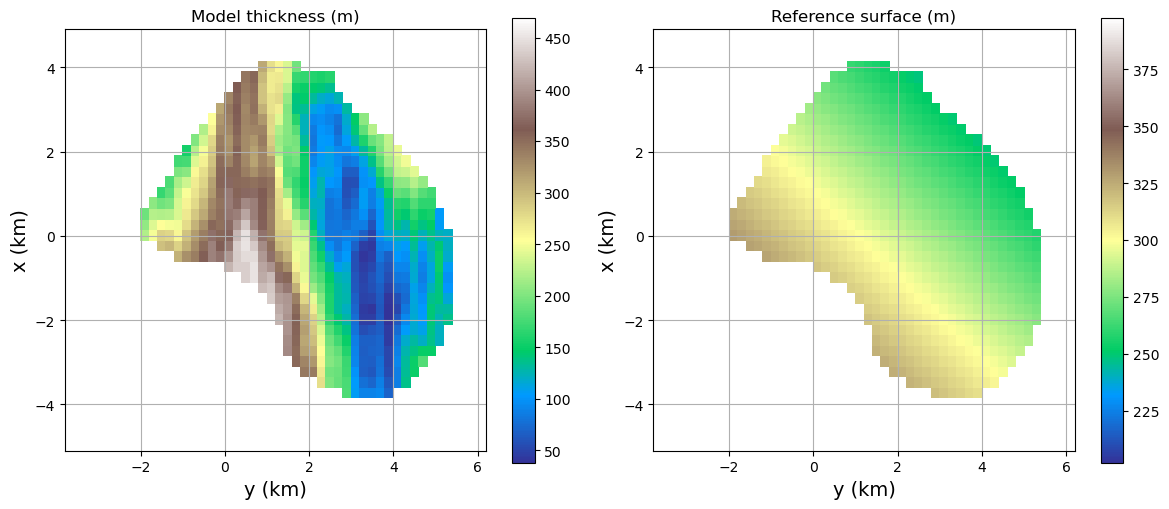

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Model thickness (m)")
plt.axis('scaled')
plt.pcolor(
    np.ma.masked_where(condition=np.invert(mask), a=Y*0.001), 
    np.ma.masked_where(condition=np.invert(mask), a=X*0.001), 
    np.ma.masked_where(condition=np.invert(mask), a=thickness), 
    cmap='terrain'
)
plt.colorbar()
plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.title("Reference surface (m)")
plt.axis('scaled')
plt.pcolor(
    np.ma.masked_where(condition=np.invert(mask), a=Y*0.001), 
    np.ma.masked_where(condition=np.invert(mask), a=X*0.001), 
    np.ma.masked_where(condition=np.invert(mask), a=reference_surface), 
    cmap='terrain',
    vmin = np.min(reference_surface), vmax = np.max(reference_surface)
)
plt.colorbar()
plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()

plt.tight_layout()

plt.show()

In [21]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

model = pickle.load(open('models/complex_model_2/model.pickle', 'rb'))

In [22]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

mag_intensity = pickle.load(open('models/complex_model_2/mag_intensity.pickle', 'rb'))
mag_inc = pickle.load(open('models/complex_model_2/mag_inc.pickle', 'rb'))
mag_dec = pickle.load(open('models/complex_model_2/mag_dec.pickle', 'rb'))

In [23]:
# compute the Cartesian components of magnetization
mx, my, mz = utils.magnetization_components(
    np.vstack([mag_intensity, mag_inc, mag_dec]).T
)

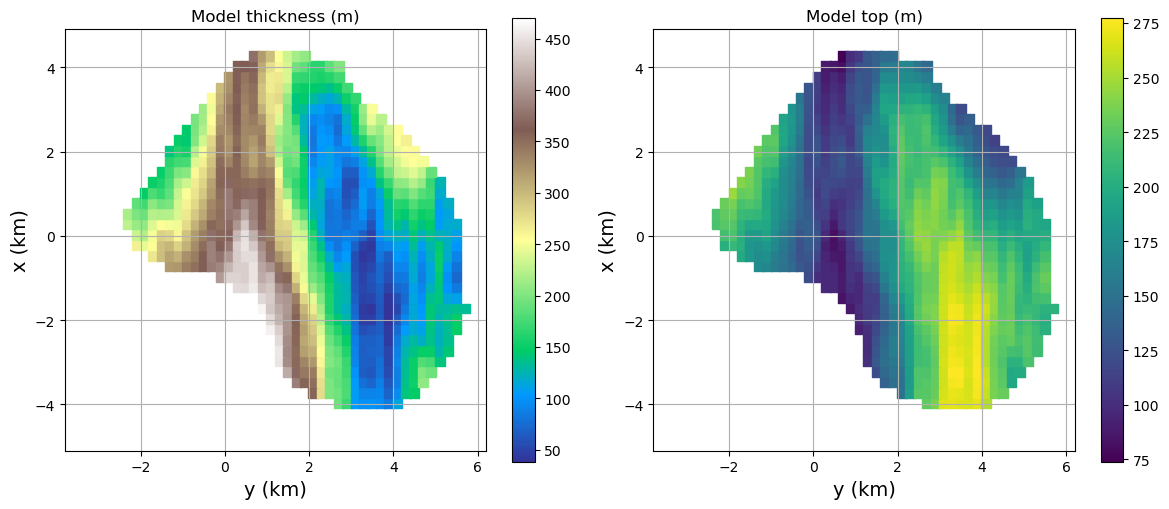

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Model thickness (m)")
plt.axis('scaled')
plt.scatter(
    x=0.5*(model['y1']+model['y2'])*0.001, 
    y=0.5*(model['x1']+model['x2'])*0.001, 
    s=50,
    c=model['z2']-model['z1'],
    marker='s',
    cmap='terrain'
)
plt.colorbar()
plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.title("Model top (m)")
plt.axis('scaled')
plt.scatter(
    x=0.5*(model['y1']+model['y2'])*0.001, 
    y=0.5*(model['x1']+model['x2'])*0.001,  
    s=50,
    c=model['z1'],
    marker='s',
    cmap='viridis'
)
plt.colorbar()
plt.ylim(0.001*model_area[0], 0.001*model_area[1])
plt.xlim(0.001*model_area[2], 0.001*model_area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()

plt.tight_layout()

plt.show()

### 3D Plot and/or save the model

In [25]:
model_mesh = plf.prisms_to_pyvista(model, mag_intensity)

In [26]:
camera_azimuths = [i for i in range(0, 360, 30)]
camera_elevations = [0, 30, 60]

for i, camera_elevation in enumerate(camera_elevations):
    for j, camera_azimuth in enumerate(camera_azimuths):

        # Run this cell to create and save the model.
        # Set this cel as 'Raw' if you want load a predefined model.
        
        pv.set_plot_theme('dark')
        
        pl = pv.Plotter()
        #pl.set_background('gray')
        
        #parameters of model colorbar
        model_sargs = dict(
            title='total-magnetization intensity (A/m)',
            title_font_size=20,
            label_font_size=16,
            shadow=True,
            n_labels=7,
            italic=True,
            fmt="%.1f",
            font_family="arial",
        )
        
        # add model
        pl.add_mesh(
            model_mesh,
            scalars='prop',
            cmap='viridis',
            lighting=True,
            scalar_bar_args=model_sargs,
            show_edges=True,
        )
        
        # set visualization parameters
        # the order of the commands below changes the result
        pl.camera_position = 'zy'
        pl.camera.roll = -90
        pl.camera.azimuth = camera_azimuth
        pl.camera.elevation = camera_elevation
        pl.camera.zoom(1.1)
        
        # the parameter zscale set the vertical exaggeration
        pl.set_scale(zscale=3)
        
        pl.show_axes()
        
        # show the interactive plot
        #pl.show()
        
        # save the image in an external file
        pl.screenshot('models/complex_model_2/complex_model_2_{}{}.png'.format(i, j), return_img=False)

In [27]:
# Run this cell to create and save the model.
# Set this cel as 'Raw' if you want load a predefined model.

# create a gif from generated images
imagemagick_command = "convert -delay 100 -loop 0 " 
for i, camera_elevation in enumerate(camera_elevations):
    for j, camera_azimuth in enumerate(camera_azimuths):
        imagemagick_command += 'complex_model_2_{}{}.png '.format(i,j)
imagemagick_command += "complex_model_2.gif"

Execute the following command at the directory `models/complex_model_2/`:

In [28]:
print(imagemagick_command)

convert -delay 100 -loop 0 complex_model_2_00.png complex_model_2_01.png complex_model_2_02.png complex_model_2_03.png complex_model_2_04.png complex_model_2_05.png complex_model_2_06.png complex_model_2_07.png complex_model_2_08.png complex_model_2_09.png complex_model_2_010.png complex_model_2_011.png complex_model_2_10.png complex_model_2_11.png complex_model_2_12.png complex_model_2_13.png complex_model_2_14.png complex_model_2_15.png complex_model_2_16.png complex_model_2_17.png complex_model_2_18.png complex_model_2_19.png complex_model_2_110.png complex_model_2_111.png complex_model_2_20.png complex_model_2_21.png complex_model_2_22.png complex_model_2_23.png complex_model_2_24.png complex_model_2_25.png complex_model_2_26.png complex_model_2_27.png complex_model_2_28.png complex_model_2_29.png complex_model_2_210.png complex_model_2_211.png complex_model_2.gif


# plot image generated with PyVista
<img src='models/complex_model_2/complex_model_2.gif' width='750' align='center'>

### Points were we compute the synthetic data

In [29]:
# number of points along x and y
shape = (300, 330)
print('n. data = {}'.format(shape[0]*shape[1]))

# minimum x, maximum x, minimum y and maximum y
area = [-5100, 4900, -3800, 6200]

# grid spacing
dx, dy = data_structures.grid_xy_spacing(area=area, shape=shape)
print('dx = {:.3f} m | dx = {:.3f} m'.format(dx, dy))

n. data = 99000
dx = 33.445 m | dx = 30.395 m


In [30]:
# grid of computation points
coordinates_grid = data_structures.grid_xy(area=area, shape=shape, z0=-150)

In [31]:
print('num. data points = {}'.format(coordinates_grid['shape'][0]*coordinates_grid['shape'][1]))

num. data points = 99000


In [32]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

### Main field

In [33]:
# reference point
xc = 0.5*(model_area[0]+model_area[1])
yc = 0.5*(model_area[2]+model_area[3])

# polynomial function defining the inclination (degrees)
I0 = -30 + 1e-5*(X-xc) - 3e-4*(Y-yc)

# polynomial function defining the declination (degrees)
D0 = 19 - 1e-3*(X-xc) + 1e-4*(Y-yc)

# polynomial function defining the intensity (nT)
F0 = 23400 + 1e-3*(X-xc) + 1e-3*(Y-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

# rearrange the computed field components and angle directions into 1d arrays
I0 = data_structures.grid_xy_full_matrix_to_flatten(grid = I0, ordering = 'xy')
D0 = data_structures.grid_xy_full_matrix_to_flatten(grid = D0, ordering = 'xy')
F0 = data_structures.grid_xy_full_matrix_to_flatten(grid = F0, ordering = 'xy')
Fx = data_structures.grid_xy_full_matrix_to_flatten(grid = Fx, ordering = 'xy')
Fy = data_structures.grid_xy_full_matrix_to_flatten(grid = Fy, ordering = 'xy')
Fz = data_structures.grid_xy_full_matrix_to_flatten(grid = Fz, ordering = 'xy')

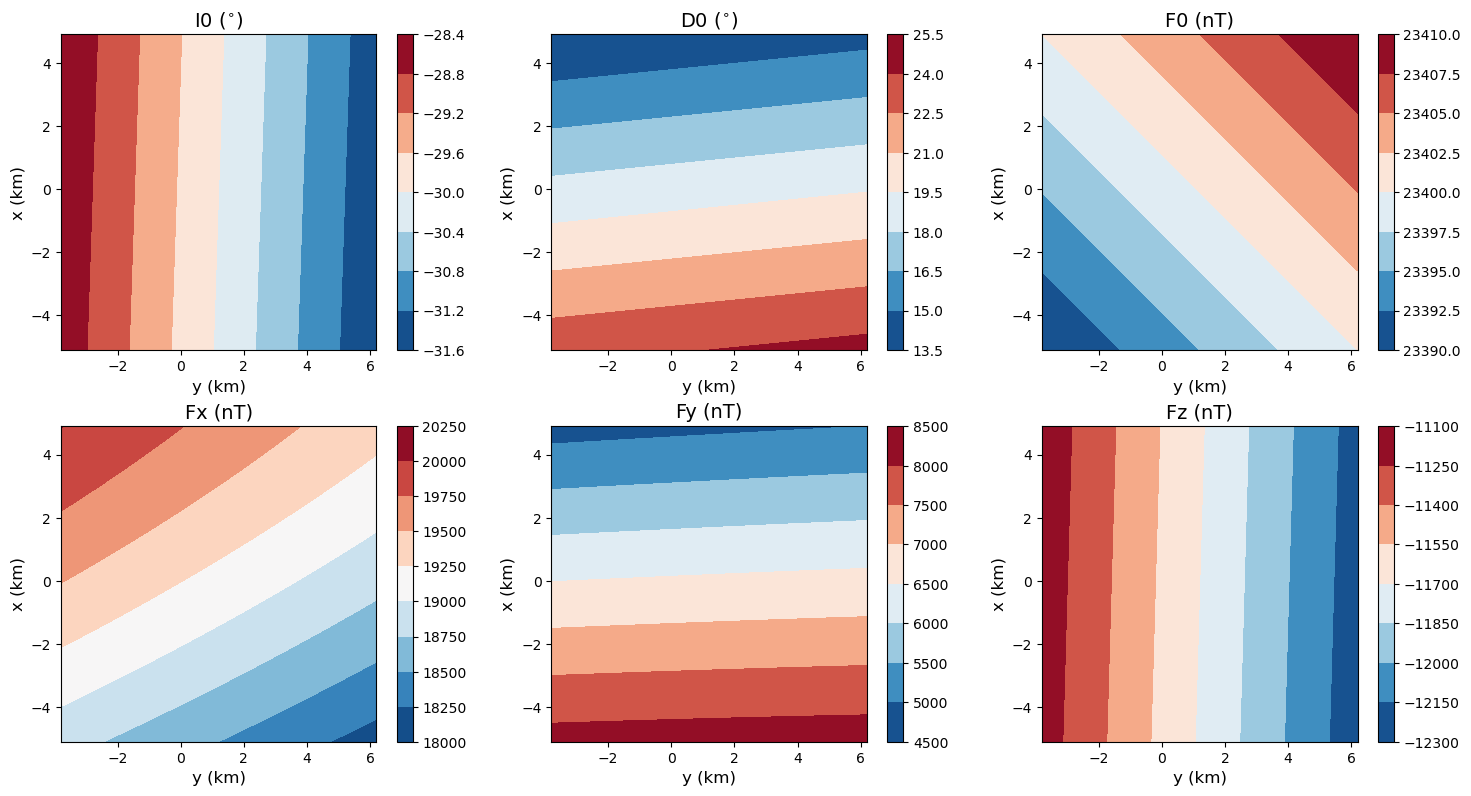

In [34]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r'
    )
    plt.colorbar()
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic magnetic data

In [35]:
V = pickle.load(open('models/complex_model_2/magnetic_potential.pickle', 'rb'))

In [36]:
bx = pickle.load(open('models/complex_model_2/magnetic_field_component_bx.pickle', 'rb'))
by = pickle.load(open('models/complex_model_2/magnetic_field_component_by.pickle', 'rb'))
bz = pickle.load(open('models/complex_model_2/magnetic_field_component_bz.pickle', 'rb'))

In [37]:
b_amp = np.sqrt(bx**2 + by**2 + bz**2)

# Compute the total-field anomaly
tfa = np.sqrt((Fx + bx)**2 + (Fy + by)**2 + (Fz + bz)**2) - F0

# Compute the approximated total-field anomaly (Blakely, 1996, p. 179)
# by using the average main geomagnetic field on the simulated area
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### Plot the data

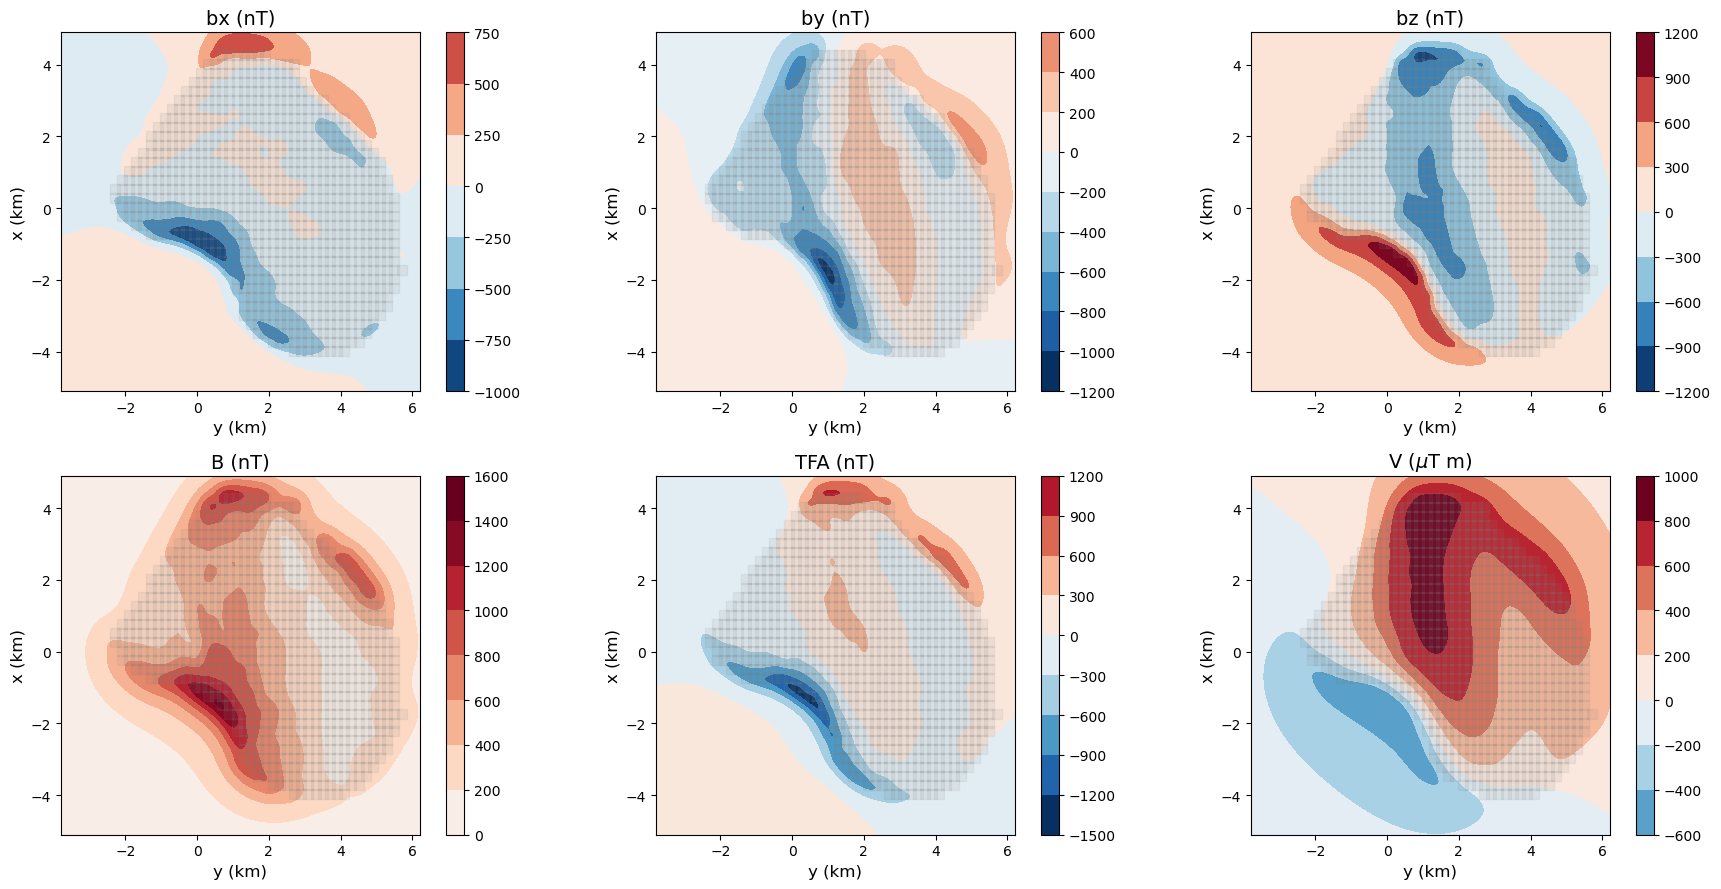

In [38]:
fields = [bx, by, bz, b_amp, tfa, V]
windows = [1, 2, 3, 4, 5, 6]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 
          'B (nT)', 'TFA (nT)', 'V ($\mu$T m)']

plt.figure(figsize=(18,9))

for w, window in enumerate(windows):
    bounds = np.max(np.abs(fields[w]))
    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin=-bounds, vmax=bounds)
    plt.colorbar()

    # horizontal projection of the model
    plt.scatter(
        x=0.5*(model['y1']+model['y2'])*0.001, 
        y=0.5*(model['x1']+model['x2'])*0.001,  
        s=50,
        c='gray',
        marker='s',
        alpha=0.1
    )
    
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

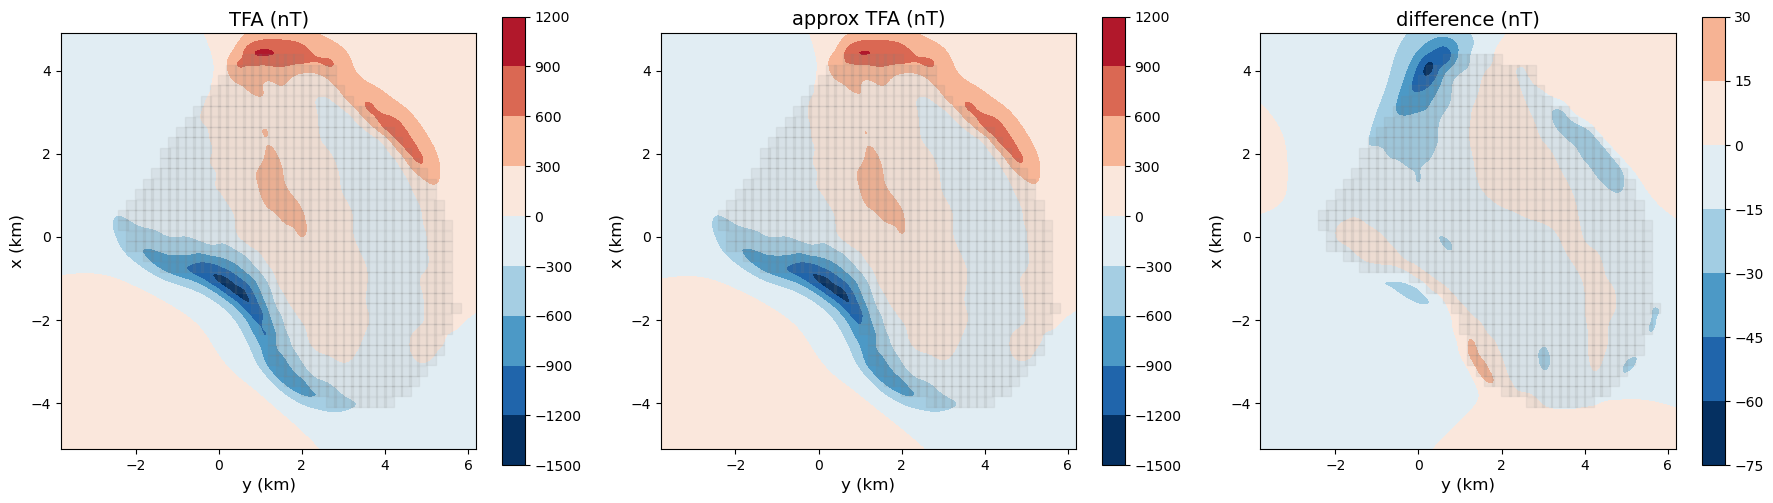

In [39]:
fields = [tfa, approx_tfa, diff_tfa]
windows = [1, 2, 3]
titles = ['TFA (nT)', 'approx TFA (nT)', 'difference (nT)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):
    bounds = np.max(np.abs(fields[w]))
    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin=-bounds, vmax=bounds)
    plt.colorbar()

    # horizontal projection of the model
    plt.scatter(
        x=0.5*(model['y1']+model['y2'])*0.001, 
        y=0.5*(model['x1']+model['x2'])*0.001,  
        s=50,
        c='gray',
        marker='s',
        alpha=0.1
    )
    
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()